In [2]:
import pandas as pd
import matplotlib.pyplot as plt
pd.options.display.max_colwidth = 100
from IPython.display import display
import os
import warnings
import numpy as np
from scipy import interpolate
from scipy import signal
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

new_rc_params = {'text.usetex': False, "svg.fonttype": 'none'}
plt.rcParams.update(new_rc_params)

sns.set_style({'font.family':'sans-serif', 'font.sans-serif':'Arial'})
plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams['font.family'] = "sans-serif"

def ImpulseFunction(t, vecImpulseParam):
    return (1/vecImpulseParam[3]) * (vecImpulseParam[2] + (vecImpulseParam[3] - vecImpulseParam[2]) * (1/(1 + np.exp(-vecImpulseParam[1] * (t - vecImpulseParam[5]))))) * (vecImpulseParam[4] + (vecImpulseParam[3] - vecImpulseParam[4]) * (1/(1 + np.exp(vecImpulseParam[1] * (t - vecImpulseParam[6])))))

def ImpulseEvaluate(vecTimepoints, vecImpulseParam):
    vecImpulseValue = [ImpulseFunction(i, vecImpulseParam) for i in vecTimepoints]
    vecImpulseOutput = [i if i > 10^(-10) else 10^(-10) for i in vecImpulseValue] 
    return vecImpulseOutput

def get_last(string):
    dummy_array = string.split(';')
    if 'eggNOG-name' in dummy_array[-1].split('='):
        return dummy_array[-1].replace('eggNOG-name=', '')
    else:
        return dummy_array[-1]
    
def igv_to_peak(string):
    contig_contig = string.split(':')[0]
    contig_coords = string.split(':')[1]
    contig_start = contig_coords.split('-')[0]
    contig_end = contig_coords.split('-')[1]
    contig = contig_contig + '_' + str(int(contig_start) - 1) + '_' + contig_end
    return contig

#taken from a Stack Overflow post
#https://stackoverflow.com/questions/2566412/find-nearest-value-in-numpy-array
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

# Import ImpulseDE2 Results
Import results for all the data as well as the noS21S22 data, sort valuesby padj, and display table.

In [3]:
#Set variables
padj_threshold = 0.01

#Load files
ImpulseDE_results = pd.DataFrame(pd.read_csv('OmniATAC-Seq_bothruns_ImpulseDE2_thpf.csv'))
ImpulseDE_results_noS21S22 = pd.DataFrame(pd.read_csv('OmniATAC-Seq_bothruns_ImpulseDE2_thpf_noS21S22.csv'))

#Sort files and drop NaN rows and filter by p-value
ImpulseDE_sorted = ImpulseDE_results.sort_values("padj").dropna(axis = 0, thresh = 3)
ImpulseDE_sorted = ImpulseDE_sorted[ImpulseDE_sorted['padj'] < padj_threshold]
ImpulseDE_noS21S22_sorted = ImpulseDE_results_noS21S22.sort_values("padj").dropna(axis = 0, thresh = 3)
ImpulseDE_noS21S22_sorted = ImpulseDE_noS21S22_sorted[ImpulseDE_noS21S22_sorted['padj'] < padj_threshold]

#Display each table
print('ImpulseDE2_all:')
display(ImpulseDE_sorted)
print('ImpulseDE2_noS21S22:')
display(ImpulseDE_noS21S22_sorted)

ImpulseDE2_all:


,Unnamed: 0,Gene,p,padj,loglik_full,loglik_red,df_full,df_red,mean,converge_impulse,converge_const,converge_sigmoid,impulseTOsigmoid_p,impulseTOsigmoid_padj,sigmoidTOconst_p,sigmoidTOconst_padj,isTransient,isMonotonous,allZero
90398,phaw_50.282695a_25060871_25061840,phaw_50.282695a_25060871_25061840,0.000000,0.000000,-198.779384,-1124.097515,7.0,2.0,554.314229,0.0,0.0,0.0,1.968017e-231,2.550129e-227,1.571157e-170,2.864559e-168,True,False,False
77628,phaw_50.282396a_3475204_3476735,phaw_50.282396a_3475204_3476735,0.000000,0.000000,-176.098844,-1350.411565,7.0,2.0,1012.747711,0.0,0.0,0.0,6.793468e-10,5.194315e-09,0.000000e+00,0.000000e+00,False,True,False
122234,phaw_50.283811_33237155_33237847,phaw_50.283811_33237155_33237847,0.000000,0.000000,-137.778732,-1027.792574,7.0,2.0,244.814625,0.0,0.0,0.0,3.808138e-261,8.635429e-257,1.499230e-125,1.200774e-123,True,False,False
166185,phaw_50.283866_8413981_8414772,phaw_50.283866_8413981_8414772,0.000000,0.000000,-167.328689,-1007.058666,7.0,2.0,449.282230,0.0,0.0,0.0,1.909335e-53,2.670567e-51,3.235523e-311,7.158003e-308,True,False,False
127128,phaw_50.283815c_32616128_32617309,phaw_50.283815c_32616128_32617309,0.000000,0.000000,-174.182437,-995.100080,7.0,2.0,618.472253,0.0,0.0,0.0,2.961933e-10,2.387153e-09,0.000000e+00,0.000000e+00,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65825,phaw_50.143217_8_373,phaw_50.143217_8_373,0.008987,0.009988,-177.367836,-185.040204,7.0,2.0,207.292801,0.0,0.0,0.0,1.483436e-03,3.384760e-03,5.090914e-01,5.504683e-01,False,False,False
131968,phaw_50.283821_10895487_10896151,phaw_50.283821_10895487_10896151,0.008987,0.009988,-125.875947,-133.548260,7.0,2.0,73.886234,0.0,0.0,0.0,1.625211e-01,2.157742e-01,8.442715e-03,1.115671e-02,False,False,False
51797,phaw_50.049043_197_643,phaw_50.049043_197_643,0.008991,0.009993,-123.882365,-131.554131,7.0,2.0,69.807638,0.0,0.0,0.0,4.702929e-01,5.510896e-01,3.138961e-03,4.315501e-03,False,False,False
36778,phaw_50.014740_778_1179,phaw_50.014740_778_1179,0.008992,0.009994,-110.380310,-118.051959,7.0,2.0,37.290747,0.0,0.0,0.0,1.761104e-03,3.944170e-03,4.471244e-01,4.877588e-01,False,False,False


ImpulseDE2_noS21S22:


,Unnamed: 0,Gene,p,padj,loglik_full,loglik_red,df_full,df_red,mean,converge_impulse,converge_const,converge_sigmoid,impulseTOsigmoid_p,impulseTOsigmoid_padj,sigmoidTOconst_p,sigmoidTOconst_padj,isTransient,isMonotonous,allZero
156756,phaw_50.283861b_10669042_10669934,phaw_50.283861b_10669042_10669934,0.000000,0.000000,-110.837180,-1078.869683,7.0,2.0,234.985198,0.0,0.0,0.0,1.383968e-12,2.865392e-11,0.000000,0.000000,False,True,False
129939,phaw_50.283817f_1601297_1602142,phaw_50.283817f_1601297_1602142,0.000000,0.000000,-114.515304,-872.472648,7.0,2.0,279.978652,0.0,0.0,0.0,1.831926e-02,4.225102e-02,0.000000,0.000000,False,True,False
178780,phaw_50.283869d_3839463_3840393,phaw_50.283869d_3839463_3840393,0.000000,0.000000,-123.546783,-1598.383977,7.0,2.0,591.065096,0.0,0.0,0.0,5.535451e-08,5.229047e-07,0.000000,0.000000,False,True,False
29382,phaw_50.007301a_4185495_4186828,phaw_50.007301a_4185495_4186828,0.000000,0.000000,-138.524614,-1014.742851,7.0,2.0,447.164565,0.0,0.0,0.0,1.105805e-15,3.561229e-14,0.000000,0.000000,True,False,False
84346,phaw_50.282639a_11874582_11875892,phaw_50.282639a_11874582_11875892,0.000000,0.000000,-125.843055,-1018.026609,7.0,2.0,463.210620,0.0,0.0,0.0,2.476251e-05,1.324068e-04,0.000000,0.000000,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11106,phaw_50.000203b_11028733_11029061,phaw_50.000203b_11028733_11029061,0.008666,0.009995,-105.009203,-112.725413,7.0,2.0,43.323741,0.0,0.0,0.0,1.146015e-01,1.915444e-01,0.011198,0.014286,False,False,False
170877,phaw_50.283867d_6971513_6971805,phaw_50.283867d_6971513_6971805,0.008667,0.009996,-100.882527,-108.598656,7.0,2.0,43.488709,0.0,0.0,0.0,2.558157e-03,7.894110e-03,0.321369,0.353198,False,False,False
48456,phaw_50.033067_198_843,phaw_50.033067_198_843,0.008667,0.009996,-139.785654,-147.501749,7.0,2.0,138.780156,0.0,0.0,0.0,1.904554e-02,4.365553e-02,0.057293,0.068358,False,False,False
125797,phaw_50.283815c_6415624_6416061,phaw_50.283815c_6415624_6416061,0.008667,0.009996,-114.641251,-122.357317,7.0,2.0,110.277113,0.0,0.0,0.0,1.174603e-03,4.014937e-03,0.585272,0.620939,False,False,False


# Import model fits at given timepoints

In [4]:
#Imports, formats, and cleans model fits for all stages
ImpulseDE2_allstages_modelfits = pd.DataFrame(pd.read_csv('OmniATAC-Seq_bothruns_ImpulseDE2_modelfits_thpf.csv'))
ImpulseDE2_allstages_modelfits.columns = ['Index', 'S13A', 'S13B', 'S14A', 'S14B', 'S15A', 'S15B', 'S17A', 'S17B', 'S18A', 'S18B', 'S19A', 'S19B', 'S19plusA', 'S19plusB', 'S20A', 'S20B', 'S21A', 'S21B', 'S22A', 'S22B', 'S23A', 'S23B', 'S24A', 'S24B', 'S25A', 'S25B', 'S26A', 'S26B', 'S27A', 'S27B', 'contig_start_end', 'max']
ImpulseDE2_allstages_modelfits = ImpulseDE2_allstages_modelfits.drop(columns = ['Index', 'max'])
ImpulseDE2_allstages_modelfits = ImpulseDE2_allstages_modelfits.add_suffix('_fit_all')
ImpulseDE2_allstages_modelfits = ImpulseDE2_allstages_modelfits.rename(columns = {'contig_start_end_fit_all':'contig_start_end'})

print('ImpulseDE2_all_modelfits:')
display(ImpulseDE2_allstages_modelfits)

#Imports, formats, and cleans model fits noS21S22 stages
ImpulseDE2_noS2122_modelfits = pd.DataFrame(pd.read_csv('OmniATAC-Seq_bothruns_ImpulseDE2_modelfits_thpf_noS21S22.csv'))
ImpulseDE2_noS2122_modelfits.columns = ['Index', 'S13A', 'S13B', 'S14A', 'S14B', 'S15A', 'S15B', 'S17A', 'S17B', 'S18A', 'S18B', 'S19A', 'S19B', 'S19plusA', 'S19plusB', 'S20A', 'S20B', 'S23A', 'S23B', 'S24A', 'S24B', 'S25A', 'S25B', 'S26A', 'S26B', 'S27A', 'S27B', 'contig_start_end', 'max']
ImpulseDE2_noS2122_modelfits = ImpulseDE2_noS2122_modelfits.drop(columns = ['Index', 'max'])
ImpulseDE2_noS2122_modelfits = ImpulseDE2_noS2122_modelfits.add_suffix('_fit_noS21S22')
ImpulseDE2_noS2122_modelfits = ImpulseDE2_noS2122_modelfits.rename(columns = {'contig_start_end_fit_noS21S22':'contig_start_end'})

print('ImpulseDE2_noS2122_modelfits:')
display(ImpulseDE2_noS2122_modelfits)

#Gets raw values for read mapping counts per replicate from multicov
multicov = pd.DataFrame(pd.read_csv('OmniATAC_bothruns_multicov_forDESeq.tsv', sep = '\t'))
display(multicov)

ImpulseDE2_all_modelfits:


,S13A_fit_all,S13B_fit_all,S14A_fit_all,S14B_fit_all,S15A_fit_all,S15B_fit_all,S17A_fit_all,S17B_fit_all,S18A_fit_all,S18B_fit_all,...,S23B_fit_all,S24A_fit_all,S24B_fit_all,S25A_fit_all,S25B_fit_all,S26A_fit_all,S26B_fit_all,S27A_fit_all,S27B_fit_all,contig_start_end
0,381.535737,381.535737,381.031632,381.031632,380.480291,380.480291,377.615354,377.615354,375.112461,375.112461,...,302.319770,317.686685,317.686685,321.040412,321.040412,321.485238,321.485238,321.554487,321.554487,phaw_50.000003_4302_5642
1,38.883695,38.883695,38.883695,38.883695,38.883695,38.883695,38.883695,38.883695,38.883695,38.883695,...,34.095463,34.095216,34.095216,34.096337,34.096337,49.812811,49.812811,49.813311,49.813311,phaw_50.000009_11628_11888
2,383.453481,383.453481,357.172798,357.172798,341.755238,341.755238,307.399464,307.399464,293.561355,293.561355,...,167.545571,166.251768,166.251768,170.473316,170.473316,177.429510,177.429510,185.214634,185.214634,phaw_50.000014_206406_207519
3,54.424261,54.424261,54.424261,54.424261,54.423787,54.423787,32.529762,32.529762,32.529633,32.529633,...,32.529633,32.529633,32.529633,32.529633,32.529633,32.529634,32.529634,120.268451,120.268451,phaw_50.000014_238984_239410
4,86.658113,86.658113,86.658852,86.658852,131.393967,131.393967,131.566678,131.566678,131.566678,131.566678,...,88.248995,88.248995,88.248995,88.248995,88.248995,88.248995,88.248995,88.248995,88.248995,phaw_50.000014_239711_240244
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181405,41.056420,41.056420,34.513564,34.513564,31.145452,31.145452,24.903782,24.903782,22.884425,22.884425,...,38.826584,53.402778,53.402778,70.513665,70.513665,82.349453,82.349453,89.598861,89.598861,phaw_50.283875b_1496273_1496592
181406,16.925954,16.925954,16.929448,16.929448,26.923184,26.923184,40.355763,40.355763,40.355763,40.355763,...,40.355763,40.355763,40.355763,40.355763,40.355763,40.355765,40.355765,85.343482,85.343482,phaw_50.283875b_1535466_1535680
181407,163.481409,163.481409,164.517185,164.517185,165.565848,165.565848,170.462633,170.462633,174.400429,174.400429,...,375.205393,334.072496,334.072496,322.524940,322.524940,320.512933,320.512933,320.110527,320.110527,phaw_50.283875b_1546841_1547714
181408,792.869442,792.869442,792.802968,792.802968,792.240166,792.240166,712.762580,712.762580,579.475336,579.475336,...,382.336352,382.336352,382.336352,382.336352,382.336352,382.336352,382.336352,382.336352,382.336352,phaw_50.283876_1905_3313


ImpulseDE2_noS2122_modelfits:


,S13A_fit_noS21S22,S13B_fit_noS21S22,S14A_fit_noS21S22,S14B_fit_noS21S22,S15A_fit_noS21S22,S15B_fit_noS21S22,S17A_fit_noS21S22,S17B_fit_noS21S22,S18A_fit_noS21S22,S18B_fit_noS21S22,...,S23B_fit_noS21S22,S24A_fit_noS21S22,S24B_fit_noS21S22,S25A_fit_noS21S22,S25B_fit_noS21S22,S26A_fit_noS21S22,S26B_fit_noS21S22,S27A_fit_noS21S22,S27B_fit_noS21S22,contig_start_end
0,405.061695,405.061695,405.843081,405.843081,438.560462,438.560462,340.082630,340.082630,329.128738,329.128738,...,328.907525,328.907525,328.907525,328.907525,328.907525,328.907525,328.907525,328.907525,328.907525,phaw_50.000003_4302_5642
1,40.124188,40.124188,40.124188,40.124188,40.124188,40.124188,40.119554,40.119554,37.419855,37.419855,...,36.613583,36.613583,36.613583,36.613586,36.613586,50.505817,50.505817,50.505819,50.505819,phaw_50.000009_11628_11888
2,370.407912,370.407912,358.623543,358.623543,350.030432,350.030432,325.152436,325.152436,312.439490,312.439490,...,142.789540,154.849682,154.849682,173.456545,173.456545,186.472640,186.472640,193.993897,193.993897,phaw_50.000014_206406_207519
3,69.735481,69.735481,69.734070,69.734070,28.623790,28.623790,28.621200,28.621200,28.621200,28.621200,...,28.621200,28.621200,28.621200,28.621200,28.621200,28.621200,28.621200,121.968144,121.968144,phaw_50.000014_238984_239410
4,88.372412,88.372412,88.380391,88.380391,133.703922,133.703922,133.955042,133.955042,133.955042,133.955042,...,96.308101,96.308101,96.308101,96.308101,96.308101,96.308101,96.308101,96.308101,96.308101,phaw_50.000014_239711_240244
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181405,41.577745,41.577745,35.153506,35.153506,31.813148,31.813148,25.551773,25.551773,23.500501,23.500501,...,38.237978,52.981586,52.981586,70.980132,70.980132,83.911533,83.911533,92.050700,92.050700,phaw_50.283875b_1496273_1496592
181406,18.544730,18.544730,20.081450,20.081450,21.055054,21.055054,23.484589,23.484589,24.596176,24.596176,...,53.093617,61.119707,61.119707,71.642410,71.642410,82.344965,82.344965,93.964569,93.964569,phaw_50.283875b_1535466_1535680
181407,150.137379,150.137379,157.983742,157.983742,163.733169,163.733169,180.766138,180.766138,189.805544,189.805544,...,383.419972,369.181624,369.181624,339.893487,339.893487,316.161127,316.161127,300.586620,300.586620,phaw_50.283875b_1546841_1547714
181408,847.979328,847.979328,795.324773,795.324773,762.071843,762.071843,682.287936,682.287936,648.264855,648.264855,...,363.920711,377.431605,377.431605,402.828145,402.828145,425.426292,425.426292,442.293129,442.293129,phaw_50.283876_1905_3313


,contig_start_end,S13A,S13B,S14A,S14B,S15A,S15B,S17A,S17B,S18A,...,S23A,S23B,S24A,S24B,S25A,S25B,S26A,S26B,S27A,S27B
0,phaw_50.000003_4302_5642,499,745,378,483,497,346,369,396,346,...,302,350,356,363,339,248,353,271,180,248
1,phaw_50.000009_11628_11888,38,52,26,65,41,48,42,57,44,...,21,37,29,51,35,35,63,49,24,35
2,phaw_50.000014_206406_207519,542,740,307,395,382,281,341,375,315,...,108,129,181,172,177,190,188,151,109,143
3,phaw_50.000014_238984_239410,94,107,64,92,31,18,39,35,60,...,3,19,14,6,14,5,7,6,75,94
4,phaw_50.000014_239711_240244,153,165,57,91,156,106,120,126,94,...,130,123,107,160,128,170,28,41,36,84
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190073,phaw_50.283875b_1535466_1535680,25,43,12,13,24,28,28,10,34,...,44,31,86,79,52,86,92,73,42,83
190074,phaw_50.283875b_1546841_1547714,155,261,113,247,182,153,209,209,163,...,361,384,366,525,267,288,298,276,200,244
190075,phaw_50.283875b_1548468_1548807,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
190076,phaw_50.283876_1905_3313,1075,1506,825,805,840,694,765,862,582,...,318,342,422,375,453,370,410,383,211,397


# Calculating fit from impulse parameters
After extracting the actual impulse function parameters from ImpulseDE2, you can plot the functions using the cell below (the base functions are at the top of this document).

Text(0.5, 0, 'hours post fertilization')

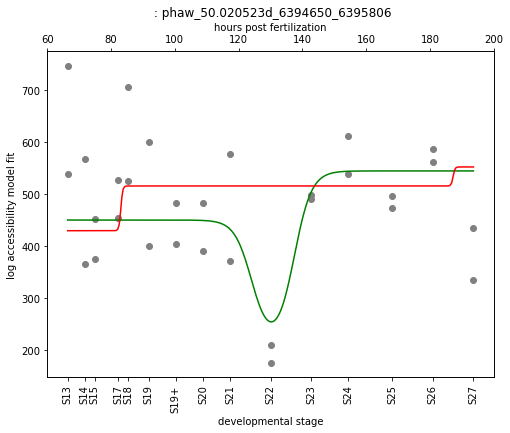

In [6]:
#Input raw contig string from IGV here
contig_string = 'phaw_50.020523d:6394651-6395806'
nickname = ''

############
############

contig = igv_to_peak(contig_string)

#contig = 'phaw_50.283864a_3320701_3323202'
plot_name = contig + '.pdf'

#Load in the ImpulseDE2 function parameters
ImpulseParams_all = pd.DataFrame(pd.read_csv('OmniATAC-Seq_bothruns_ImpulseDE2_ImpulseParams_thpf.csv'))
ImpulseParams_noS21S22 = pd.DataFrame(pd.read_csv('OmniATAC-Seq_bothruns_ImpulseDE2_ImpulseParams_thpf_noS21S22.csv'))

#Extract the parameters for your line of interest
impulse_params_for_contig_all = ImpulseParams_all.loc[ImpulseParams_all['contig_start_end'] == contig].drop(columns = ['Unnamed: 0']).values.tolist()[0]
impulse_params_for_contig_noS21S22 = ImpulseParams_noS21S22.loc[ImpulseParams_noS21S22['contig_start_end'] == contig].drop(columns = ['Unnamed: 0']).values.tolist()[0]
all_multicov = multicov.loc[multicov['contig_start_end'] == contig].drop(columns = ['contig_start_end']).astype('float').values.tolist()[0]

#Calculate fit given Impulse function expected ranges
x_impulse_linspace = np.linspace(72, 192, 300)
x_impulse = [72, 77, 80, 87, 90, 96, 104, 112, 120, 132, 144, 155, 168, 180, 192]
x_impulse = [i for i in x_impulse for _ in (0, 1)]
impulse_fit_all = ImpulseEvaluate(x_impulse_linspace, impulse_params_for_contig_all)
impulse_fit_noS21S22 = ImpulseEvaluate(x_impulse_linspace, impulse_params_for_contig_noS21S22)

#Plot lines
fig, ax = plt.subplots(figsize=(8,6))
plt.title(nickname + ' : ' + contig)
plt.plot(x_impulse_linspace, impulse_fit_all, c = 'green')
plt.plot(x_impulse_linspace, impulse_fit_noS21S22, c = 'red')
plt.scatter(x_impulse, all_multicov, c = 'gray')
plt.ylabel('log accessibility model fit')
plt.xlabel('developmental stage')
plt.xticks([72, 77, 80, 87, 90, 96, 104, 112, 120, 132, 144, 155, 168, 180, 192], ['S13', 'S14', 'S15', 'S17', 'S18', 'S19', 'S19+', 'S20', 'S21', 'S22', 'S23', 'S24', 'S25', 'S26', 'S27'], rotation = 'vertical')
    
ax2range = [i for i in range(60, 220, 20)]
ax2 = plt.twiny()
ax2.set_xticks([(i - 60) / (200 - 60) for i in ax2range])
ax2.set_xticklabels(ax2range)
ax2.set_xlabel('hours post fertilization')

#fig.savefig(plot_name, bbox_inches='tight')

# Generate plot of regions within a genomic coordinate

Text(0.5, 0, 'hours post fertilization')

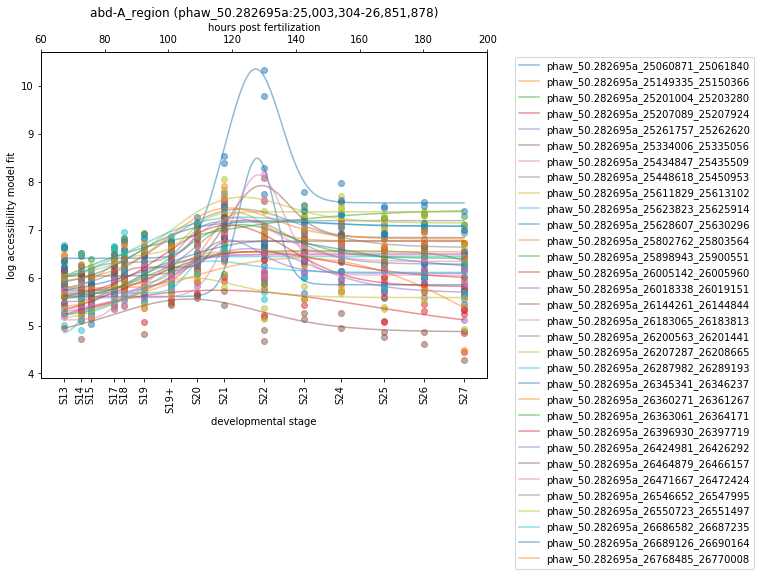

In [90]:
#Input the IGV address of the region you want to extract
igv_address = 'phaw_50.282695a:25,003,304-26,851,878'
nickname = 'abd-A_region'

#set the location of the fasta file you want to extract from
fasta_file = '~/Labwork/Bioinformatics/GenomeSequences/Phaw_5.0_Annotation/genome/phaw_5.0.fa'
#set the destination directory for your output fasta files
output_destination = '~/Labwork/Bioinformatics/ContigsandScaffolds/'

#set the location of the peak region file you want to compare to
peaks_file = '~/Labwork/Bioinformatics/Omni-ATAC-Seq/OmniATAC_bothruns_peaks/OmniATAC_bothruns_q005_allpeaks.igv_new.bed'

#region_list = peaks_list
plot_all = True
plot_points = True

#filters the peaks based on the number of timepoints during which they are accessible
#minimum of 0 and maximum of 15
accessibility_score_filter = 14

#Decompose the IGV address into component parts
contig = igv_address.split(':')[0]
start = igv_address.split(':')[1].split('-')[0].replace(',', '')
end = igv_address.split(':')[1].split('-')[1].replace(',', '')
igv_address_stripped = igv_address.replace(',', '').replace(':', '_').replace('-', '_')

plot_name = nickname + '_' + igv_address_stripped + '.pdf'

####################################################
####################################################

#Make a dummy region of interest bed file
region = contig + '\t' + start + '\t' + end
region_name = contig + '_' + start + '_' + end
region_bed = 'dummy_region.bed'
with open(region_bed, 'w+') as f:
    f.write(region)

#Run this block to get the fasta file of peaks overlapping your region of interest
region_peaks_bed = 'dummy_region_peaks.bed'
!bedtools intersect -wa -a $peaks_file -b $region_bed > $region_peaks_bed
peaks = pd.read_csv(region_peaks_bed, sep = '\t', header = None)
peaks = peaks[peaks[3] >= accessibility_score_filter]
peaks[5] = peaks[0] + "_" + peaks[1].astype('str') + "_" + peaks[2].astype('str')
#display(peaks)
peaks_temp = peaks[5].values
peaks_list = [i for i in peaks_temp if i in ImpulseParams_all['contig_start_end'].values]

fig, ax = plt.subplots(figsize=(8,6))

for region in peaks_list:
    #Calculate fit given Impulse function expected ranges
    x_impulse_linspace = np.linspace(72, 192, 300)
    x_impulse = [72, 77, 80, 87, 90, 96, 104, 112, 120, 132, 144, 155, 168, 180, 192]
    x_impulse = [i for i in x_impulse for _ in (0, 1)]

    #Plot lines
    if plot_all == True:
        impulse_params_for_contig_all = ImpulseParams_all.loc[ImpulseParams_all['contig_start_end'] == region].drop(columns = ['Unnamed: 0']).values.tolist()[0]
        impulse_fit_all = ImpulseEvaluate(x_impulse_linspace, impulse_params_for_contig_all)
        plt.plot(x_impulse_linspace, np.log(impulse_fit_all), alpha = 0.5, label = region)
    if plot_points == True:
        all_multicov = multicov.loc[multicov['contig_start_end'] == region].drop(columns = ['contig_start_end']).astype('float').values.tolist()[0]
        plt.scatter(x_impulse, np.log(all_multicov), alpha = 0.5)
    plt.title(nickname + ' (' + igv_address + ')')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.ylabel('log accessibility model fit')
    plt.xlabel('developmental stage')
    plt.xticks([72, 77, 80, 87, 90, 96, 104, 112, 120, 132, 144, 155, 168, 180, 192], ['S13', 'S14', 'S15', 'S17', 'S18', 'S19', 'S19+', 'S20', 'S21', 'S22', 'S23', 'S24', 'S25', 'S26', 'S27'], rotation = 'vertical')
    
ax2range = [i for i in range(60, 220, 20)]
ax2 = plt.twiny()
ax2.set_xticks([(i - 60) / (200 - 60) for i in ax2range])
ax2.set_xticklabels(ax2range)
ax2.set_xlabel('hours post fertilization')

#fig.savefig(plot_name, bbox_inches='tight')

# Plot multiple lines, given list of regions, in log scale

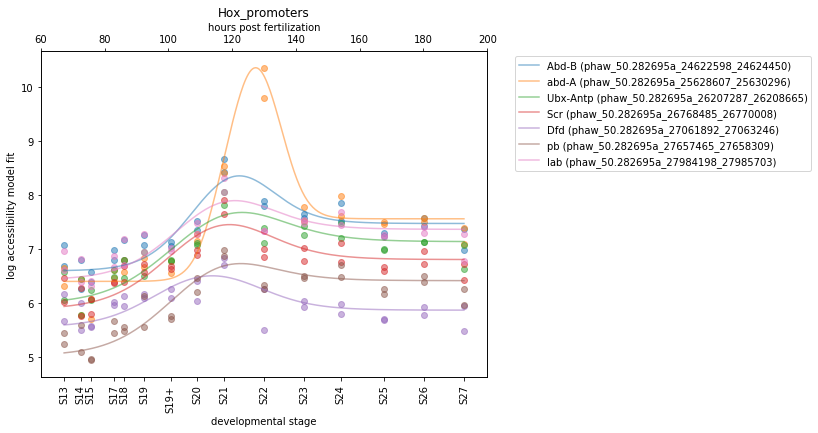

In [92]:
#Input the list of IGV addresses for the regions you want to plot
nickname = 'Hox_promoters'
igv_addresses = {
                 'Abd-B': 'phaw_50.282695a:24622599-24624450',
                 'abd-A': 'phaw_50.282695a:25628608-25630296',
                 'Ubx-Antp': 'phaw_50.282695a:26207288-26208665',
                 'Scr': 'phaw_50.282695a:26768486-26770008',
                 'Dfd': 'phaw_50.282695a:27061893-27063246',
                 'pb': 'phaw_50.282695a:27657466-27658309',
                 'lab': 'phaw_50.282695a:27984199-27985703'
                }

plot_all = True
plot_points = True
save_fig = False

####################################################
####################################################

peaks_list = {i: igv_to_peak(igv_addresses[i]) for i in igv_addresses}

plot_name = nickname + '_region_list.pdf'

fig, ax = plt.subplots(figsize=(8,6))

for name, region in peaks_list.items():
    #Calculate fit given Impulse function expected ranges
    x_impulse_linspace = np.linspace(72, 192, 300)
    x_impulse = [72, 77, 80, 87, 90, 96, 104, 112, 120, 132, 144, 155, 168, 180, 192]
    x_impulse = [i for i in x_impulse for _ in (0, 1)]

    #Plot lines
    if plot_all == True:
        impulse_params_for_contig_all = ImpulseParams_all.loc[ImpulseParams_all['contig_start_end'] == region].drop(columns = ['Unnamed: 0']).values.tolist()[0]
        impulse_fit_all = ImpulseEvaluate(x_impulse_linspace, impulse_params_for_contig_all)
        plt.plot(x_impulse_linspace, np.log(impulse_fit_all), alpha = 0.5, label = name + ' (' + region + ')')
    if plot_points == True:
        all_multicov = multicov.loc[multicov['contig_start_end'] == region].drop(columns = ['contig_start_end']).astype('float').values.tolist()[0]
        plt.scatter(x_impulse, np.log(all_multicov), alpha = 0.5)
    plt.title(nickname)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.ylabel('log accessibility model fit')
    plt.xlabel('developmental stage')
    plt.xticks([72, 77, 80, 87, 90, 96, 104, 112, 120, 132, 144, 155, 168, 180, 192], ['S13', 'S14', 'S15', 'S17', 'S18', 'S19', 'S19+', 'S20', 'S21', 'S22', 'S23', 'S24', 'S25', 'S26', 'S27'], rotation = 'vertical')
    
ax2range = [i for i in range(60, 220, 20)]
ax2 = plt.twiny()
ax2.set_xticks([(i - 60) / (200 - 60) for i in ax2range])
ax2.set_xticklabels(ax2range)
ax2.set_xlabel('hours post fertilization')

if save_fig == True:
    fig.savefig(plot_name, bbox_inches='tight')

# Identify point of maximum accessibility and stability in model

In [7]:
noS21S22_summary = ImpulseDE_results_noS21S22[['Gene', 'padj', 'isTransient', 'isMonotonous']]
noS21S22_summary = noS21S22_summary.rename(columns = {'padj': 'padj_noS21S22','isTransient':'isTransient_noS21S22', 'isMonotonous':'isMonotonous_noS21S22'})
ImpulseDE_sigstable = ImpulseDE_sorted.merge(noS21S22_summary, on = 'Gene')
ImpulseDE_sigstable

timepoints_for_max = [72, 77, 80, 87, 90, 96, 104, 112, 120, 132, 144, 155, 168, 180, 192]
stages_for_max = [13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]
dict_for_max = dict(zip(timepoints_for_max, stages_for_max))

ImpulseDE_sigstable_maxpoints = pd.DataFrame(columns = ['contig_start_end', 'max_all', 'max_S21S22', 'stage_all', 'stage_S21S22', 'stage_diff'])
for i in ImpulseDE_sigstable['Gene']:
    impulse_params_for_contig_all = ImpulseParams_all.loc[ImpulseParams_all['contig_start_end'] == i].drop(columns = ['Unnamed: 0']).values.tolist()[0]
    impulse_params_for_contig_noS21S22 = ImpulseParams_noS21S22.loc[ImpulseParams_noS21S22['contig_start_end'] == i].drop(columns = ['Unnamed: 0']).values.tolist()[0]
    x_impulse_linspace = np.linspace(72, 192, 300)
    
    impulse_fit_all = ImpulseEvaluate(x_impulse_linspace, impulse_params_for_contig_all)
    impulse_fit_all_max_index = [i for i, j in enumerate(impulse_fit_all) if j == max(impulse_fit_all)]
    impulse_fit_all_max_temp = np.mean(impulse_fit_all_max_index)/ 300 * (192 - 72) + 72
    impulse_fit_all_max_bin = find_nearest(timepoints_for_max, impulse_fit_all_max_temp)
    impulse_fit_all_max_stage = dict_for_max[impulse_fit_all_max_bin]
    
    impulse_fit_noS21S22 = ImpulseEvaluate(x_impulse_linspace, impulse_params_for_contig_noS21S22)
    impulse_fit_noS21S22_max_index = [i for i, j in enumerate(impulse_fit_noS21S22) if j == max(impulse_fit_noS21S22)]
    impulse_fit_noS21S22_max_temp = np.mean(impulse_fit_noS21S22_max_index)/ 300 * (192 - 72) + 72
    impulse_fit_noS21S22_max_bin = find_nearest(timepoints_for_max, impulse_fit_noS21S22_max_temp)
    impulse_fit_noS21S22_max_stage = dict_for_max[impulse_fit_noS21S22_max_bin]
    
    ImpulseDE_sigstable_maxpoints = ImpulseDE_sigstable_maxpoints.append({
        'contig_start_end': i,
        'max_all': impulse_fit_all_max_bin,
        'max_all_temp': impulse_fit_all_max_temp,
        'stage_all': impulse_fit_all_max_stage,
        'max_S21S22': impulse_fit_noS21S22_max_bin,
        'stage_S21S22': impulse_fit_noS21S22_max_stage,
        'stage_diff': abs(impulse_fit_all_max_stage - impulse_fit_noS21S22_max_stage)
    }, ignore_index=True)
display(ImpulseDE_sigstable_maxpoints)

ImpulseDE_sigstable_maxpoints.to_csv("OmniATAC-Seq_bothruns_ImpulseDE2_sigstable_max_thpf.tsv", sep="\t", index=None)

<ipython-input-2-171fa3be5520>:16: RuntimeWarning: overflow encountered in exp
  return (1/vecImpulseParam[3]) * (vecImpulseParam[2] + (vecImpulseParam[3] - vecImpulseParam[2]) * (1/(1 + np.exp(-vecImpulseParam[1] * (t - vecImpulseParam[5]))))) * (vecImpulseParam[4] + (vecImpulseParam[3] - vecImpulseParam[4]) * (1/(1 + np.exp(vecImpulseParam[1] * (t - vecImpulseParam[6])))))


,contig_start_end,max_all,max_S21S22,stage_all,stage_S21S22,stage_diff,max_all_temp
0,phaw_50.282695a_25060871_25061840,132,144,22,23,1,129.6
1,phaw_50.282396a_3475204_3476735,192,192,27,27,0,191.6
2,phaw_50.283811_33237155_33237847,120,120,21,21,0,123.2
3,phaw_50.283866_8413981_8414772,132,132,22,22,0,130.0
4,phaw_50.283815c_32616128_32617309,144,155,23,24,1,144.4
...,...,...,...,...,...,...,...
163222,phaw_50.143217_8_373,192,80,27,15,12,191.6
163223,phaw_50.283821_10895487_10896151,72,72,13,13,0,72.0
163224,phaw_50.049043_197_643,72,72,13,13,0,74.2
163225,phaw_50.014740_778_1179,168,192,25,27,2,165.8


# Remove non-stable maxes, calculate % remain, plot differences

0.9189656123067875


,contig_start_end,max_all,max_S21S22,stage_all,stage_S21S22,stage_diff,max_all_temp
0,phaw_50.282695a_25060871_25061840,132,144,22,23,1,129.6
1,phaw_50.282396a_3475204_3476735,192,192,27,27,0,191.6
2,phaw_50.283811_33237155_33237847,120,120,21,21,0,123.2
3,phaw_50.283866_8413981_8414772,132,132,22,22,0,130.0
4,phaw_50.283815c_32616128_32617309,144,155,23,24,1,144.4
...,...,...,...,...,...,...,...
163221,phaw_50.282695a_5047751_5048148,72,72,13,13,0,72.0
163223,phaw_50.283821_10895487_10896151,72,72,13,13,0,72.0
163224,phaw_50.049043_197_643,72,72,13,13,0,74.2
163225,phaw_50.014740_778_1179,168,192,25,27,2,165.8


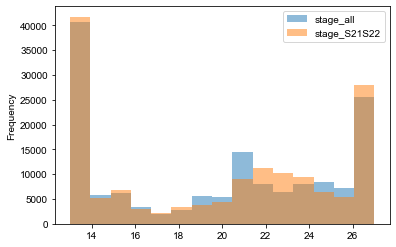

In [8]:
ImpulseDE_sigstable_maxpoints = pd.DataFrame(pd.read_csv("OmniATAC-Seq_bothruns_ImpulseDE2_sigstable_max_thpf.tsv", sep="\t")).drop_duplicates(subset='contig_start_end', keep='first')

ImpulseDE_sigstable_stable = ImpulseDE_sigstable_maxpoints[ImpulseDE_sigstable_maxpoints['stage_diff'] <= 4]
print(len(ImpulseDE_sigstable_stable) / len(ImpulseDE_sigstable_maxpoints))
display(ImpulseDE_sigstable_stable)

ImpulseDE_sigstable_stable.to_csv("OmniATAC-Seq_bothruns_ImpulseDE2_sigstable_stable_thpf.tsv", sep="\t", index=None)

ax = ImpulseDE_sigstable_stable[['stage_all', 'stage_S21S22']].plot.hist(bins = 15, alpha = 0.5)
fig = ax.get_figure()
fig.savefig('ImpulseDE_peak_hist_thpf2022.svg', bbox_inches='tight')

ImpulseDE_first = ImpulseDE_sigstable_stable[ImpulseDE_sigstable_stable["stage_all"] <= 15]

ImpulseDE_second = ImpulseDE_sigstable_stable[ImpulseDE_sigstable_stable["stage_all"] <= 18]
ImpulseDE_second = ImpulseDE_second[ImpulseDE_second["stage_all"] >= 16]

ImpulseDE_third = ImpulseDE_sigstable_stable[ImpulseDE_sigstable_stable["stage_all"] <= 21]
ImpulseDE_third = ImpulseDE_third[ImpulseDE_third["stage_all"] >= 19]

ImpulseDE_fourth = ImpulseDE_sigstable_stable[ImpulseDE_sigstable_stable["stage_all"] <= 24]
ImpulseDE_fourth = ImpulseDE_fourth[ImpulseDE_fourth["stage_all"] >= 22]

ImpulseDE_fifth = ImpulseDE_sigstable_stable[ImpulseDE_sigstable_stable["stage_all"] >= 25]


hist_orig1 = [ImpulseDE_sigstable_maxpoints[ImpulseDE_sigstable_maxpoints['stage_all'] <= 15].index,
            ImpulseDE_sigstable_maxpoints[(ImpulseDE_sigstable_maxpoints['stage_all'] <= 18) & (ImpulseDE_sigstable_maxpoints['stage_all'] >= 16)].index,
            ImpulseDE_sigstable_maxpoints[(ImpulseDE_sigstable_maxpoints['stage_all'] <= 21) & (ImpulseDE_sigstable_maxpoints['stage_all'] >= 19)].index,
            ImpulseDE_sigstable_maxpoints[(ImpulseDE_sigstable_maxpoints['stage_all'] <= 24) & (ImpulseDE_sigstable_maxpoints['stage_all'] >= 22)].index,
            ImpulseDE_sigstable_maxpoints[ImpulseDE_sigstable_maxpoints['stage_all'] >= 25].index]
hist_orig = [len(i) for i in hist_orig1]

[0.9730383557090359,
 0.8636168384879725,
 0.832258064516129,
 0.8623277182235835,
 0.9596485899203252]

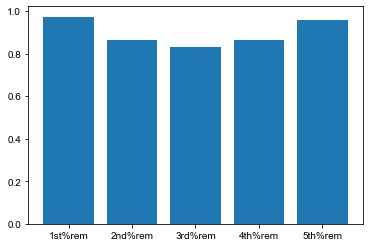

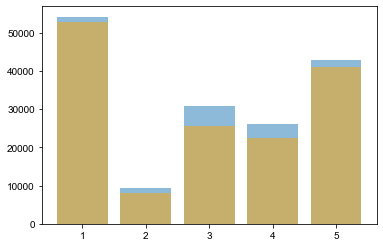

In [9]:
hist_new = [len(ImpulseDE_first),
               len(ImpulseDE_second),
               len(ImpulseDE_third),
               len(ImpulseDE_fourth),
               len(ImpulseDE_fifth)]

hist_remain = [hist_new[i]/hist_orig[i] for i in np.arange(0, 5)]
display(hist_remain)
fig1 = plt.figure()
plt.bar(height = hist_remain, x = ["1st%rem", "2nd%rem", "3rd%rem", "4th%rem", "5th%rem"])
fig1.savefig('ImpulseDE_peak_percentremain_thpf2022.svg', bbox_inches='tight')

fig2 = plt.figure()
plt.bar(height = hist_orig, x = [1, 2, 3, 4, 5], alpha = 0.5)
plt.bar(height = hist_new, x = [1, 2, 3, 4, 5], color='orange', alpha = 0.5)
fig2.savefig('ImpulseDE_peak_histremain_thpf2022.svg', bbox_inches='tight')

# Load in closest data
Loads in closest:
1. Non-overlapping peak per mRNA. This includes promoters and proximal enhancers.
2. Overlapping peak per mRNA. This should mostly be promoters, but could also be intronic CREs.
3. Closest mRNA per peak. This is the crude way to assign function to each peak.

# Proximal peak identification

# Get closest mRNA annotation per peak

# Get list of genes per quintile and total gene list for GO enrichment

# Convert total gene lists to lists per species

# Display GO term heatmap for peaks

1. Extracted gene names from eggnog annotation for peaks that achieve max accessibility within each quintile.
2. Ran GO term enrichment using Drosophila as a background. (For each list, ~50% genes were non-Drosophila).

# Interpret DESeq2 PCA loadings

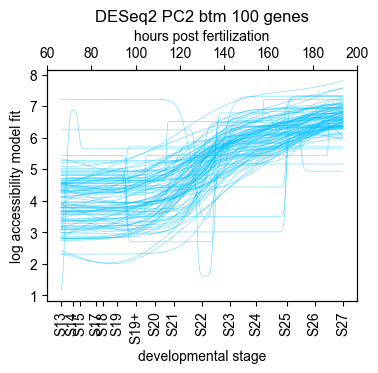

In [32]:
DESeq2_loadings = pd.DataFrame(pd.read_csv('OmniATAC_bothruns_DESeq2_rotation_matrix.csv'))
DESeq2_PCs = pd.DataFrame(pd.read_csv('OmniATAC_bothruns_DESeq2_PC_matrix.csv'))

#Load in the ImpulseDE2 function parameters
ImpulseParams_all = pd.DataFrame(pd.read_csv('OmniATAC-Seq_bothruns_ImpulseDE2_ImpulseParams_thpf.csv'))
ImpulseParams_noS21S22 = pd.DataFrame(pd.read_csv('OmniATAC-Seq_bothruns_ImpulseDE2_ImpulseParams_thpf_noS21S22.csv'))

top_num = 100
PCnum = 'PC2'
categoryis = 'btm'
save_fig = True
plot_all = True
fmt = 'svg'

####################################################
####################################################

#dummy variables
toporbtm = 'null'
plotcolor = 'black'

if categoryis == 'top':
    toporbtm = False
    plotcolor = 'orangered'
elif categoryis == 'btm':
    toporbtm = True
    plotcolor = 'deepskyblue'
else:
    raise('Need to specify top or btm')

top_PC1 = DESeq2_loadings.sort_values(PCnum, ascending=toporbtm).head(top_num)['Unnamed: 0']
top_PC1
#bottom_PC1 = DESeq2_loadings.sort_values("PC1", ascending=True).head(100)['contig_start_end']
peaks_list = [i for i in top_PC1 if i in ImpulseParams_all['contig_start_end'].values]

plot_name = 'DESeq2_' + PCnum + '_' + categoryis + str(top_num) + '_thpf.' + fmt

fig, ax = plt.subplots(figsize=(4,3))

for region in peaks_list:
    #Calculate fit given Impulse function expected ranges
    x_impulse_linspace = np.linspace(72, 192, 300)
    x_impulse = [72, 77, 80, 87, 90, 96, 104, 112, 120, 132, 144, 155, 168, 180, 192]
    x_impulse = [i for i in x_impulse for _ in (0, 1)]

    #Plot lines
    if plot_all == True:
        impulse_params_for_contig_all = ImpulseParams_all.loc[ImpulseParams_all['contig_start_end'] == region].drop(columns = ['Unnamed: 0']).values.tolist()[0]
        impulse_fit_all = ImpulseEvaluate(x_impulse_linspace, impulse_params_for_contig_all)
        plt.plot(x_impulse_linspace, np.log(impulse_fit_all), alpha = 0.5, color = plotcolor, label = region, linewidth = 0.5)
    plt.title('DESeq2 ' + PCnum + ' ' + categoryis + ' ' + str(top_num) + ' genes')
    plt.ylabel('log accessibility model fit')
    plt.xlabel('developmental stage')
    plt.xticks([72, 77, 80, 87, 90, 96, 104, 112, 120, 132, 144, 155, 168, 180, 192], ['S13', 'S14', 'S15', 'S17', 'S18', 'S19', 'S19+', 'S20', 'S21', 'S22', 'S23', 'S24', 'S25', 'S26', 'S27'], rotation = 'vertical', fontsize = 10)
    plt.yticks(fontsize = 10)

ax2range = [i for i in range(60, 220, 20)]
ax2 = plt.twiny()
ax2.set_xticks([(i - 60) / (200 - 60) for i in ax2range])
ax2.set_xticklabels(ax2range, fontsize = 10)
ax2.set_xlabel('hours post fertilization')

if save_fig == True:
    fig.savefig(plot_name, bbox_inches='tight')

# PCA on ImpulseDE2 parameters on all peaks

# t-SNE on ImpulseDE2 model fits

# t-SNE plot of raw counts data

In [133]:
top_n = 25000
perplexity = 40

stages = ['S13A', 'S13B', 'S14A', 'S14B', 'S15A', 'S15B', 'S17A', 'S17B', 'S18A', 'S18B', 'S19A', 'S19B', 'S19plusA', 'S19plusB', 'S20A', 'S20B', 'S21A', 'S21B', 'S22A', 'S22B', 'S23A', 'S23B', 'S24A', 'S24B', 'S25A', 'S25B', 'S26A', 'S26B', 'S27A', 'S27B']
multicov_top_n = ImpulseParams_stable.head(top_n).loc[:, stages].values

tsne = TSNE(n_components=2, verbose=1, perplexity=perplexity, n_iter=300)
tsne_results = tsne.fit_transform(multicov_top_n)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 25000 samples in 0.086s...
[t-SNE] Computed neighbors for 25000 samples in 13.779s...
[t-SNE] Computed conditional probabilities for sample 1000 / 25000
[t-SNE] Computed conditional probabilities for sample 2000 / 25000
[t-SNE] Computed conditional probabilities for sample 3000 / 25000
[t-SNE] Computed conditional probabilities for sample 4000 / 25000
[t-SNE] Computed conditional probabilities for sample 5000 / 25000
[t-SNE] Computed conditional probabilities for sample 6000 / 25000
[t-SNE] Computed conditional probabilities for sample 7000 / 25000
[t-SNE] Computed conditional probabilities for sample 8000 / 25000
[t-SNE] Computed conditional probabilities for sample 9000 / 25000
[t-SNE] Computed conditional probabilities for sample 10000 / 25000
[t-SNE] Computed conditional probabilities for sample 11000 / 25000
[t-SNE] Computed conditional probabilities for sample 12000 / 25000
[t-SNE] Computed conditional probabilities for s

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


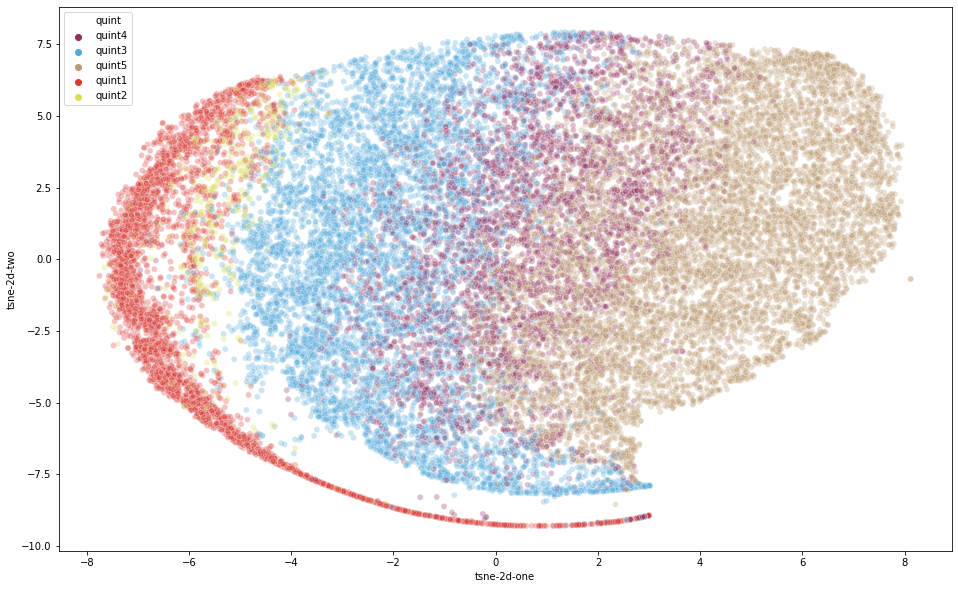

In [134]:
multicov_top_n = ImpulseParams_stable.head(top_n)
multicov_top_n['tsne-2d-one'] = tsne_results[:,0]
multicov_top_n['tsne-2d-two'] = tsne_results[:,1]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="quint",
    palette={'quint1':'#da3832', 'quint2':'#d9dd50', 'quint3':'#53a9dc', 'quint4':'#922d61', 'quint5':'#bd9b72'},
    data=multicov_top_n,
    legend="full",
    alpha=0.3
)

plt.savefig('multicov_top' + str(top_n) + '_p_' + str(perplexity) + '_tsne_quints.pdf')

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


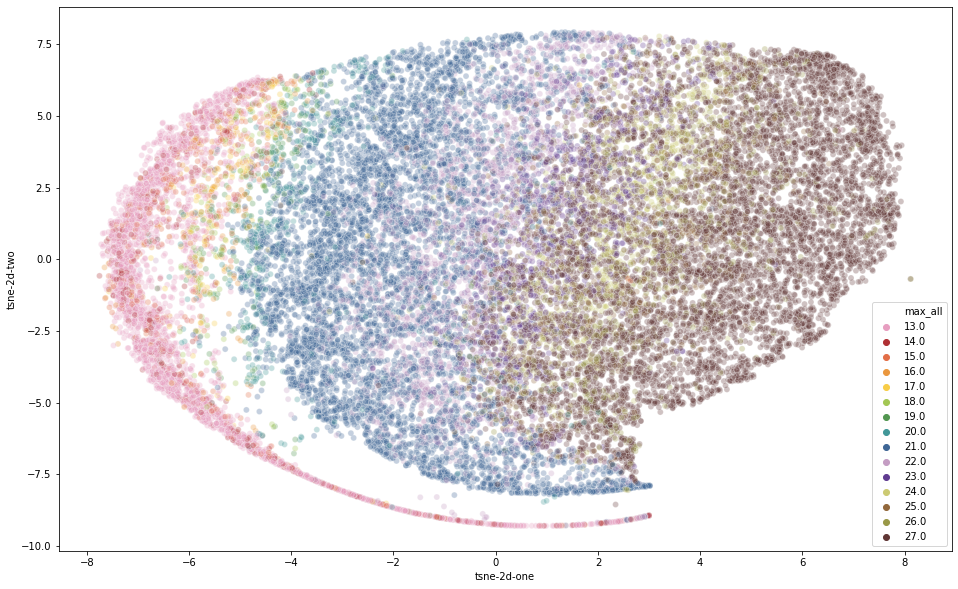

In [135]:
stage_palette = {
    13 : '#e79ec0',
    14 : '#af3034',
    15 : '#e26e47',
    16 : '#ea973e',
    17 : '#f8cd47',
    18 : '#a3c754',
    19 : '#529650',
    20 : '#429798',
    21 : '#3f6695',
    22 : '#c49dc3',
    23 : '#603c90',
    24 : '#ccca73',
    25 : '#92683c',
    26 : '#999847',
    27 : '#603635'
}

multicov_top_n = ImpulseParams_stable.head(top_n)
multicov_top_n['tsne-2d-one'] = tsne_results[:,0]
multicov_top_n['tsne-2d-two'] = tsne_results[:,1]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="max_all",
    palette=stage_palette,
    data=multicov_top_n,
    legend="full",
    alpha=0.3
)

plt.savefig('multicov_top_' + str(top_n) + '_p_' + str(perplexity) + '_tsne_stages.pdf')

In [156]:
ImpulseDE_sigstable_maxpoints = pd.read_csv("OmniATAC-Seq_bothruns_ImpulseDE2_sigstable_max.tsv", sep="\t")
ImpulseParams_forhclust = ImpulseDE_sigstable_maxpoints.merge(ImpulseParams_all)
ImpulseParams_forhclust = ImpulseParams_forhclust[['contig_start_end', 'beta', 'h0', 'h1', 'h2', 't1', 't2']].head(25000)

ImpulseParams_forhclust.to_csv("OmniATAC-Seq_bothruns_ImpulseDE2_top25k_forhclust.tsv", sep="\t", index = None)

# Processing data for Mfuzz

In [62]:
import pandas as pd
from sklearn import preprocessing

multicov = pd.DataFrame(pd.read_csv('OmniATAC_bothruns_multicov_forDESeq.tsv', sep = '\t'))

multicov_columns = ['S13A', 'S13B', 'S14A', 'S14B', 'S15A', 'S15B',
       'S17A', 'S17B', 'S18A', 'S18B', 'S19A', 'S19B', 'S19plusA', 'S19plusB',
       'S20A', 'S20B', 'S21A', 'S21B', 'S22A', 'S22B', 'S23A', 'S23B', 'S24A',
       'S24B', 'S25A', 'S25B', 'S26A', 'S26B', 'S27A', 'S27B']
multicov_names = multicov['contig_start_end']
x = multicov[multicov_columns].values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
multicov_scaled = pd.DataFrame(x_scaled, columns = multicov_columns)
multicov_scaled['contig_start_end'] = multicov_names

prox_peaks = pd.DataFrame(pd.read_csv('ImpulseDE2_sigstable_annotations.tsv', sep = '\t'))

multicov_withname = multicov_scaled.merge(prox_peaks[['contig_start_end', 'Nearby_Gene']])

display(multicov_scaled)
display(prox_peaks)

multicov_withname = multicov_withname[['contig_start_end', 'Nearby_Gene', 'S13A', 'S13B', 'S14A', 'S14B', 'S15A', 'S15B', 'S17A', 'S17B', 'S18A', 'S18B', 'S19A', 'S19B', 'S19plusA', 'S19plusB','S20A', 'S20B', 'S21A', 'S21B', 'S22A', 'S22B', 'S23A', 'S23B', 'S24A', 'S24B', 'S25A', 'S25B', 'S26A', 'S26B', 'S27A', 'S27B']].rename(columns = {'contig_start_end':'GENE.ID', 'Nearby_Gene':'GENE.NAME'}).drop_duplicates().drop_duplicates(subset='GENE.ID', keep='first')

display(multicov_withname)

multicov_withname.to_csv('OmniATAC_for_Mfuzz_normed.tsv', sep = '\t', index = None)

,S13A,S13B,S14A,S14B,S15A,S15B,S17A,S17B,S18A,S18B,...,S23B,S24A,S24B,S25A,S25B,S26A,S26B,S27A,S27B,contig_start_end
0,0.000283,0.000368,0.000124,0.000168,0.000198,0.000127,0.000171,0.000192,0.000861,0.000726,...,0.001690,0.002606,0.001585,0.002747,0.001891,0.002003,0.002530,0.002042,0.002117,phaw_50.000003_4302_5642
1,0.000022,0.000026,0.000009,0.000023,0.000016,0.000018,0.000019,0.000028,0.000109,0.000061,...,0.000179,0.000212,0.000223,0.000284,0.000267,0.000358,0.000457,0.000272,0.000299,phaw_50.000009_11628_11888
2,0.000307,0.000366,0.000101,0.000137,0.000152,0.000103,0.000158,0.000182,0.000784,0.000575,...,0.000623,0.001325,0.000751,0.001434,0.001449,0.001067,0.001410,0.001236,0.001221,phaw_50.000014_206406_207519
3,0.000053,0.000053,0.000021,0.000032,0.000012,0.000007,0.000018,0.000017,0.000149,0.000106,...,0.000092,0.000102,0.000026,0.000113,0.000038,0.000040,0.000056,0.000851,0.000802,phaw_50.000014_238984_239410
4,0.000087,0.000082,0.000019,0.000032,0.000062,0.000039,0.000056,0.000061,0.000234,0.000170,...,0.000594,0.000783,0.000699,0.001037,0.001297,0.000159,0.000383,0.000408,0.000717,phaw_50.000014_239711_240244
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190073,0.000014,0.000021,0.000004,0.000005,0.000010,0.000010,0.000013,0.000005,0.000085,0.000052,...,0.000150,0.000629,0.000345,0.000421,0.000656,0.000522,0.000682,0.000476,0.000709,phaw_50.283875b_1535466_1535680
190074,0.000088,0.000129,0.000037,0.000086,0.000072,0.000056,0.000097,0.000102,0.000406,0.000396,...,0.001854,0.002679,0.002293,0.002163,0.002197,0.001691,0.002577,0.002269,0.002083,phaw_50.283875b_1546841_1547714
190075,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,phaw_50.283875b_1548468_1548807
190076,0.000609,0.000744,0.000271,0.000280,0.000334,0.000255,0.000355,0.000419,0.001448,0.001199,...,0.001652,0.003089,0.001638,0.003671,0.002822,0.002327,0.003576,0.002393,0.003389,phaw_50.283876_1905_3313


,contig_start_end,max_all,max_S21S22,max_diff,16,Nearby_Gene
0,phaw_50.001137b_10047943_10049274,24.0,23.0,1.0,68596,polybromo
1,phaw_50.282861e_14337153_14338358,21.0,21.0,0.0,-94457,NaN
2,phaw_50.283823c_56423509_56424634,27.0,27.0,0.0,204439,NaN
3,phaw_50.283817d_2608098_2609434,27.0,27.0,0.0,-605615,NaN
4,phaw_50.282654b_8813983_8815092,21.0,21.0,0.0,63236,shakB
...,...,...,...,...,...,...
151825,phaw_50.283870_31508198_31508386,16.0,16.0,0.0,109458,NaN
151826,phaw_50.283743b_2685218_2685495,16.0,16.0,0.0,50968,NaN
151827,phaw_50.000135c_16666556_16667003,27.0,27.0,0.0,248473,NaN
151828,phaw_50.283869c_22485630_22486651,25.0,25.0,0.0,27526,NaN


,GENE.ID,GENE.NAME,S13A,S13B,S14A,S14B,S15A,S15B,S17A,S17B,...,S23A,S23B,S24A,S24B,S25A,S25B,S26A,S26B,S27A,S27B
0,phaw_50.000019_87818_88035,GXYLT1,0.000043,0.000080,0.000015,0.000023,0.000018,0.000011,0.000045,0.000035,...,0.000020,0.000063,0.000051,0.000044,0.000041,0.000084,0.000023,0.000037,0.000034,0.000009
1,phaw_50.000019_97413_97613,GXYLT1,0.000146,0.000136,0.000044,0.000074,0.000063,0.000048,0.000058,0.000074,...,0.000831,0.000517,0.000498,0.000507,0.000689,0.000671,0.000630,0.000719,0.000624,0.000546
2,phaw_50.000056_111837_112078,NaN,0.000064,0.000064,0.000027,0.000035,0.000031,0.000023,0.000028,0.000037,...,0.000323,0.000179,0.000227,0.000135,0.000357,0.000275,0.000170,0.000280,0.000272,0.000188
4,phaw_50.000056_125889_126272,NaN,0.000079,0.000079,0.000056,0.000050,0.000042,0.000028,0.000046,0.000043,...,0.000264,0.000193,0.000432,0.000227,0.000413,0.000404,0.000244,0.000364,0.000113,0.000273
6,phaw_50.000056_127667_128004,NaN,0.000025,0.000025,0.000045,0.000029,0.000033,0.000041,0.000038,0.000021,...,0.000147,0.000140,0.000110,0.000092,0.000178,0.000061,0.000148,0.000140,0.000261,0.000299
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151825,phaw_50.283875b_1468773_1469007,NaN,0.000015,0.000010,0.000012,0.000020,0.000021,0.000014,0.000016,0.000041,...,0.000528,0.000324,0.000512,0.000489,0.000648,0.000580,0.000102,0.000355,0.000204,0.000316
151826,phaw_50.283875b_1477584_1478169,NaN,0.000065,0.000054,0.000028,0.000048,0.000051,0.000030,0.000049,0.000078,...,0.001262,0.000778,0.000856,0.000729,0.000916,0.001197,0.001073,0.002157,0.001282,0.001852
151827,phaw_50.283875b_1496273_1496592,NaN,0.000044,0.000016,0.000011,0.000013,0.000019,0.000011,0.000020,0.000006,...,0.000381,0.000155,0.000388,0.000284,0.000510,0.000511,0.000431,0.000663,0.000567,0.000768
151828,phaw_50.283875b_1535466_1535680,NaN,0.000014,0.000021,0.000004,0.000005,0.000010,0.000010,0.000013,0.000005,...,0.000430,0.000150,0.000629,0.000345,0.000421,0.000656,0.000522,0.000682,0.000476,0.000709


In [4]:
import pandas as pd
from sklearn import preprocessing

multicov = pd.DataFrame(pd.read_csv('OmniATAC_bothruns_multicov_forDESeq.tsv', sep = '\t'))

prox_peaks = pd.DataFrame(pd.read_csv('ImpulseDE2_sigstable_annotations.tsv', sep = '\t'))

multicov_withname = multicov.merge(prox_peaks[['contig_start_end', 'Nearby_Gene']])

display(multicov)
display(prox_peaks)

multicov_withname = multicov_withname[['contig_start_end', 'Nearby_Gene', 'S13A', 'S13B', 'S14A', 'S14B', 'S15A', 'S15B', 'S17A', 'S17B', 'S18A', 'S18B', 'S19A', 'S19B', 'S19plusA', 'S19plusB','S20A', 'S20B', 'S21A', 'S21B', 'S22A', 'S22B', 'S23A', 'S23B', 'S24A', 'S24B', 'S25A', 'S25B', 'S26A', 'S26B', 'S27A', 'S27B']].rename(columns = {'contig_start_end':'GENE.ID', 'Nearby_Gene':'GENE.NAME'}).drop_duplicates(subset='GENE.ID', keep='first')

display(multicov_withname)

multicov_withname.to_csv('OmniATAC_for_Mfuzz.tsv', sep = '\t', index = None)

len(multicov['contig_start_end'].unique())

,contig_start_end,S13A,S13B,S14A,S14B,S15A,S15B,S17A,S17B,S18A,...,S23A,S23B,S24A,S24B,S25A,S25B,S26A,S26B,S27A,S27B
0,phaw_50.000003_4302_5642,499,745,378,483,497,346,369,396,346,...,302,350,356,363,339,248,353,271,180,248
1,phaw_50.000009_11628_11888,38,52,26,65,41,48,42,57,44,...,21,37,29,51,35,35,63,49,24,35
2,phaw_50.000014_206406_207519,542,740,307,395,382,281,341,375,315,...,108,129,181,172,177,190,188,151,109,143
3,phaw_50.000014_238984_239410,94,107,64,92,31,18,39,35,60,...,3,19,14,6,14,5,7,6,75,94
4,phaw_50.000014_239711_240244,153,165,57,91,156,106,120,126,94,...,130,123,107,160,128,170,28,41,36,84
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190073,phaw_50.283875b_1535466_1535680,25,43,12,13,24,28,28,10,34,...,44,31,86,79,52,86,92,73,42,83
190074,phaw_50.283875b_1546841_1547714,155,261,113,247,182,153,209,209,163,...,361,384,366,525,267,288,298,276,200,244
190075,phaw_50.283875b_1548468_1548807,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
190076,phaw_50.283876_1905_3313,1075,1506,825,805,840,694,765,862,582,...,318,342,422,375,453,370,410,383,211,397


,contig_start_end,max_all,max_S21S22,max_diff,16,Nearby_Gene
0,phaw_50.001137b_10047943_10049274,24.0,23.0,1.0,68596,polybromo
1,phaw_50.282861e_14337153_14338358,21.0,21.0,0.0,-94457,NaN
2,phaw_50.283823c_56423509_56424634,27.0,27.0,0.0,204439,NaN
3,phaw_50.283817d_2608098_2609434,27.0,27.0,0.0,-605615,NaN
4,phaw_50.282654b_8813983_8815092,21.0,21.0,0.0,63236,shakB
...,...,...,...,...,...,...
151825,phaw_50.283870_31508198_31508386,16.0,16.0,0.0,109458,NaN
151826,phaw_50.283743b_2685218_2685495,16.0,16.0,0.0,50968,NaN
151827,phaw_50.000135c_16666556_16667003,27.0,27.0,0.0,248473,NaN
151828,phaw_50.283869c_22485630_22486651,25.0,25.0,0.0,27526,NaN


,GENE.ID,GENE.NAME,S13A,S13B,S14A,S14B,S15A,S15B,S17A,S17B,...,S23A,S23B,S24A,S24B,S25A,S25B,S26A,S26B,S27A,S27B
0,phaw_50.000019_87818_88035,GXYLT1,76,162,46,65,46,29,97,73,...,2,13,7,10,5,11,4,4,3,1
1,phaw_50.000019_97413_97613,GXYLT1,258,276,135,214,158,131,126,153,...,85,107,68,116,85,88,111,77,55,64
2,phaw_50.000056_111837_112078,NaN,113,130,81,101,79,64,60,76,...,33,37,31,31,44,36,30,30,24,22
4,phaw_50.000056_125889_126272,NaN,140,160,169,145,106,77,100,89,...,27,40,59,52,51,53,43,39,10,32
6,phaw_50.000056_127667_128004,NaN,45,51,136,84,83,112,81,44,...,15,29,15,21,22,8,26,15,23,35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151825,phaw_50.283875b_1468773_1469007,NaN,27,21,37,57,52,38,34,85,...,54,67,70,112,80,76,18,38,18,37
151826,phaw_50.283875b_1477584_1478169,NaN,114,110,84,138,128,82,105,161,...,129,161,117,167,113,157,189,231,113,217
151827,phaw_50.283875b_1496273_1496592,NaN,78,32,33,36,47,29,44,13,...,39,32,53,65,63,67,76,71,50,90
151828,phaw_50.283875b_1535466_1535680,NaN,25,43,12,13,24,28,28,10,...,44,31,86,79,52,86,92,73,42,83


190078

In [49]:
closest_mRNA_per_peak = pd.DataFrame(pd.read_csv("OmniATAC_bothruns_q005_allpeaks_closest-mRNA-per-peak.tsv", sep = '\t', header = None))
prox_peaks = pd.DataFrame(pd.read_csv("OmniATAC-Seq_bothruns_ImpulseDE2_sigstable_max.tsv", sep="\t")).drop_duplicates(subset='contig_start_end', keep='first')
prox_peaks = prox_peaks[prox_peaks['max_diff'] <= 4]

nearest_annotation_peak = [get_last(item) for item in closest_mRNA_per_peak[13]]
closest_mRNA_per_peak['contig_start_end'] = closest_mRNA_per_peak[0].astype(str) + "_" + closest_mRNA_per_peak[1].astype(str) + "_" + closest_mRNA_per_peak[2].astype(str)
closest_mRNA_per_peak['Nearby_Gene'] = nearest_annotation_peak

closest_MPP_new_tidy = closest_mRNA_per_peak[['contig_start_end', 'Nearby_Gene']].drop_duplicates(subset='contig_start_end', keep='first')
display(closest_MPP_new_tidy)

closest_MPP_new_multicov = multicov.merge(closest_MPP_new_tidy)

closest_MPP_new_multicov = closest_MPP_new_multicov[['contig_start_end', 'Nearby_Gene', 'S13A', 'S13B', 'S14A', 'S14B', 'S15A', 'S15B', 'S17A', 'S17B', 'S18A', 'S18B', 'S19A', 'S19B', 'S19plusA', 'S19plusB','S20A', 'S20B', 'S21A', 'S21B', 'S22A', 'S22B', 'S23A', 'S23B', 'S24A', 'S24B', 'S25A', 'S25B', 'S26A', 'S26B', 'S27A', 'S27B']].rename(columns = {'contig_start_end':'GENE.ID', 'Nearby_Gene':'GENE.NAME'}).drop_duplicates(subset='GENE.ID', keep='first')

closest_MPP_new_multicov = closest_MPP_new_multicov[(closest_MPP_new_multicov[['S13A', 'S13B', 'S14A', 'S14B', 'S15A', 'S15B', 'S17A', 'S17B', 'S18A', 'S18B', 'S19A', 'S19B', 'S19plusA', 'S19plusB','S20A', 'S20B', 'S21A', 'S21B', 'S22A', 'S22B', 'S23A', 'S23B', 'S24A', 'S24B', 'S25A', 'S25B', 'S26A', 'S26B', 'S27A', 'S27B']] != 0).all(axis = 1)]

closest_MPP_new_multicov = closest_MPP_new_multicov.merge(pd.DataFrame(prox_peaks['contig_start_end']), left_on = 'GENE.ID', right_on = 'contig_start_end').drop(columns = 'contig_start_end').drop_duplicates(subset='GENE.ID', keep='first')

display(closest_MPP_new_multicov)
closest_MPP_new_multicov.to_csv('OmniATAC_for_Mfuzz_new.tsv', sep = '\t', index = None)

,contig_start_end,Nearby_Gene
0,phaw_50.000003_4302_5642,.
1,phaw_50.000009_11628_11888,.
2,phaw_50.000014_206406_207519,.
3,phaw_50.000014_238984_239410,.
4,phaw_50.000014_239711_240244,.
...,...,...
239866,phaw_50.283875b_1535466_1535680,nan
239867,phaw_50.283875b_1546841_1547714,nan
239868,phaw_50.283875b_1548468_1548807,nan
239869,phaw_50.283876_1905_3313,.


,GENE.ID,GENE.NAME,S13A,S13B,S14A,S14B,S15A,S15B,S17A,S17B,...,S23A,S23B,S24A,S24B,S25A,S25B,S26A,S26B,S27A,S27B
0,phaw_50.000003_4302_5642,.,499,745,378,483,497,346,369,396,...,302,350,356,363,339,248,353,271,180,248
1,phaw_50.000014_206406_207519,.,542,740,307,395,382,281,341,375,...,108,129,181,172,177,190,188,151,109,143
2,phaw_50.000014_238984_239410,.,94,107,64,92,31,18,39,35,...,3,19,14,6,14,5,7,6,75,94
3,phaw_50.000014_239711_240244,.,153,165,57,91,156,106,120,126,...,130,123,107,160,128,170,28,41,36,84
4,phaw_50.000019_87818_88035,GXYLT1,76,162,46,65,46,29,97,73,...,2,13,7,10,5,11,4,4,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145066,phaw_50.283875b_1496273_1496592,nan,78,32,33,36,47,29,44,13,...,39,32,53,65,63,67,76,71,50,90
145067,phaw_50.283875b_1535466_1535680,nan,25,43,12,13,24,28,28,10,...,44,31,86,79,52,86,92,73,42,83
145068,phaw_50.283875b_1546841_1547714,nan,155,261,113,247,182,153,209,209,...,361,384,366,525,267,288,298,276,200,244
145069,phaw_50.283876_1905_3313,.,1075,1506,825,805,840,694,765,862,...,318,342,422,375,453,370,410,383,211,397


# Generate summary metrics for IDE2

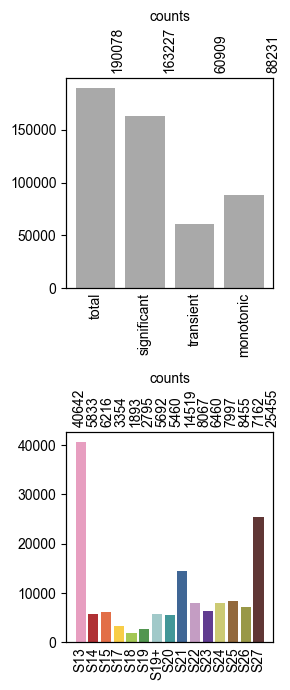

In [99]:
#Set variables
padj_threshold = 0.01

#Load files
ImpulseDE_results = pd.DataFrame(pd.read_csv('OmniATAC-Seq_bothruns_ImpulseDE2_thpf.csv'))
ImpulseDE_sig = ImpulseDE_results[ImpulseDE_results['padj'] < padj_threshold]

summary_results = {
    'total': len(ImpulseDE_results),
    'significant': len(ImpulseDE_sig),
    'transient': len(ImpulseDE_sig[ImpulseDE_sig['isTransient']]),
    'monotonic': len(ImpulseDE_sig[ImpulseDE_sig['isMonotonous']])
}

plt.figure(figsize = (3, 7))
plt.subplot(2, 1, 1)
plt.bar(summary_results.keys(), summary_results.values(), color = 'darkgrey')
plt.xticks(rotation = 90)
plt.tick_params(axis='x', which='both', length=0)

ax2 = plt.twiny()
ax2.set_xticks([i for i in np.arange(1, 5)])
ax2.set_xticklabels(summary_results.values(), rotation = 90)
ax2.set_xlabel('counts')
ax2.tick_params(axis='x', which='both', length=0)

ImpulseDE_sigstable_maxpoints = pd.DataFrame(pd.read_csv("OmniATAC-Seq_bothruns_ImpulseDE2_sigstable_max_thpf.tsv", sep="\t")).drop_duplicates(subset='contig_start_end', keep='first')
stage_max_dict = dict(ImpulseDE_sigstable_stable['stage_all'].value_counts())

stage_palette = {
    13 : '#e79ec0',
    14 : '#af3034',
    15 : '#e26e47',
    16 : '#f8cd47',
    17 : '#a3c754',
    18 : '#529650',
    19 : '#a1c9c9',
    20 : '#429798',
    21 : '#3f6695',
    22 : '#c49dc3',
    23 : '#603c90',
    24 : '#ccca73',
    25 : '#92683c',
    26 : '#999847',
    27 : '#603635'
}

resorted_dict = {}
sorted_keys = sorted(stage_max_dict.keys())
for i in sorted_keys:
    resorted_dict[i] = stage_max_dict[i]

plt.subplot(2, 1, 2)
plt.bar(resorted_dict.keys(), resorted_dict.values(), color = stage_palette.values())
plt.xticks([i for i in np.arange(13, 28)], ['S13', 'S14', 'S15', 'S17', 'S18', 'S19', 'S19+', 'S20', 'S21', 'S22', 'S23', 'S24', 'S25', 'S26', 'S27'], rotation = 90)
plt.tick_params(axis='x', which='both', length=0)

ax2 = plt.twiny()
ax2.set_xticks([i for i in np.arange(1, 16)])
ax2.set_xticklabels(resorted_dict.values(), rotation = 90)
ax2.set_xlabel('counts')
ax2.tick_params(axis='x', which='both', length=0)

plt.tight_layout()
plt.savefig("IDE2_summary_metrics.svg")

plt.show()

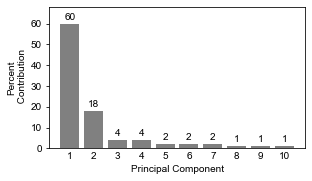

In [30]:
PC_contributions = {'PC': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                   'percentContribution': [60, 18, 4, 4, 2, 2, 2, 1, 1, 1]}

plt.figure(figsize = (4.6, 2.6))

plt.bar(PC_contributions['PC'], PC_contributions['percentContribution'], color = "gray")

ax = plt.gca()
rects = ax.patches

# Make some labels.
labels = [i for i in PC_contributions['percentContribution']]

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(
        rect.get_x() + rect.get_width() / 2, height + 1, label, ha="center", va="bottom"
    )
    
plt.ylim(0, 68)
plt.xticks([i + 1 for i in np.arange(10)], [i + 1 for i in np.arange(10)])
plt.tick_params(axis='x', which='both', length=0)

plt.ylabel('Percent\n Contribution')
plt.xlabel('Principal Component')

plt.savefig('DESeq2_PC_percentcontribution.svg')

plt.show()